In [1]:
import math
from typing import Tuple, Optional, List, Iterator
from pathlib import Path
from IPython.display import clear_output

import torchvision
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data as data
from torch import nn

import matplotlib.pyplot as plt

from tqdm import tqdm

from PIL import Image
import os
import json

import pickle

In [2]:
class FlatFolderDataset(data.Dataset):
    def __init__(self, _dir : str, size = 512):
        super().__init__()

        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(size),
            torchvision.transforms.RandomCrop(size/2),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ColorJitter(.15,.2,.2),
            torchvision.transforms.ToTensor(),
            # torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

        self.transform_test = torchvision.transforms.Compose([
            torchvision.transforms.Resize(size),
            torchvision.transforms.CenterCrop(size),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            # torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
    
        self.dir = _dir

        self.paths = os.listdir(self.dir)

    def __getitem__(self, index, train : bool = True):
        path = self.paths[index]
        try:
            img = Image.open(os.path.join(self.dir, path)).convert("RGB")
        except:
            return self[index + 1]
        if train:
            return self.transform(img)
        else:
            return self.transform_test(img)

    def __len__(self):
        return len(self.paths)

In [3]:
inv_normalize = torchvision.transforms.Normalize(
   mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
   std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

In [4]:
'''
_style_dataset = FlatFolderDataset("E:\\projects\\StyleTransferMirror\\style")

for i in range(10):
    batch = torchvision.transforms.ToPILImage()(inv_normalize(_style_dataset[np.random.randint(0, len(_style_dataset))]))
    plt.imshow(batch)
    plt.show()
'''

'\n_style_dataset = FlatFolderDataset("E:\\projects\\StyleTransferMirror\\style")\n\nfor i in range(10):\n    batch = torchvision.transforms.ToPILImage()(inv_normalize(_style_dataset[np.random.randint(0, len(_style_dataset))]))\n    plt.imshow(batch)\n    plt.show()\n'

In [5]:
'''
_content_dataset = FlatFolderDataset("E:\\projects\\StyleTransferMirror\\content")

for i in range(10):
    batch = torchvision.transforms.ToPILImage()(inv_normalize(_content_dataset[np.random.randint(0, len(_content_dataset))]))
    plt.imshow(batch)
    plt.show()
'''

'\n_content_dataset = FlatFolderDataset("E:\\projects\\StyleTransferMirror\\content")\n\nfor i in range(10):\n    batch = torchvision.transforms.ToPILImage()(inv_normalize(_content_dataset[np.random.randint(0, len(_content_dataset))]))\n    plt.imshow(batch)\n    plt.show()\n'

In [ ]:
import model

In [ ]:
class DevEnvironment():

    def __init__(self, config_file):
        '''
        config_file: path to the config file
        '''
        config = json.loads(open(config_file).read())

        self.batch_size = config["batch_size"] if "batch_size" in config else 32

        self.style_path = config["style_path"] if "style_path" in config else "E:\\projects\\StyleTransferMirror\\style"
        self.content_path = config["content_path"] if "content_path" in config else "E:\\projects\\StyleTransferMirror\\content"

        self._style_dataset = FlatFolderDataset(self.style_path)
        style_dataloader = torch.utils.data.DataLoader(self._style_dataset, batch_size = self.batch_size, shuffle=True, drop_last=True, pin_memory=True)
        self.style_loader = infinite_loader(style_dataloader)

        self._content_dataset = FlatFolderDataset(self.content_path)
        content_dataloader = torch.utils.data.DataLoader(self._content_dataset, batch_size = self.batch_size, shuffle=True, drop_last=True, pin_memory=True)
        self.content_loader = infinite_loader(content_dataloader)

        self.device = torch.device(config["device"]) if "device" in config else torch.device("cuda")

        self.vgg_encoder = model.vgg
        self.vgg_encoder.load_state_dict(torch.load("./model_save/vgg_normalised.pth"))
        self.vgg_encoder = nn.Sequential(*list(self.vgg_encoder.children())[:44])

        self.decoder = model.decoder.to(self.device)

        self.network : model.MultiLevelStyleAttention = model.MultiLevelStyleAttention(self.vgg_encoder, self.decoder)
        self.network.to(self.device)
        self.network.train()

        self.lr = config["lr"] if "lr" in config else 1e-4
        self.lr_decay = config["lr_decay"] if "lr_decay" in config else 0.99999
        self.decay_after = config["decay_after"] if "decay_after" in config else 5000

        self.iters = config["iters"] if "iters" in config else 200000

        self.optimizer = torch.optim.Adam([
            {"params": self.network.decoder.parameters()},
            {"params": self.network.sa_module.parameters()}
        ], lr=self.lr)

        self.style_weight = config["style_weight"] if "style_weight" in config else 5.0
        self.content_weight = config["content_weight"] if "content_weight" in config else 1.0
        self.identity1_weight = config["identity1_weight"] if "identity1_weight" in config else 50.0
        self.identity2_weight = config["identity2_weight"] if "identity2_weight" in config else 1.0

        self.save_checkpoint_interval = config["save_checkpoint_interval"] if "save_checkpoint_interval" in config else 1000
        self.log_generated_interval = config["log_generated_interval"] if "log_generated_interval" in config else 20
        self.img_generated_interval = config["img_generated_interval"] if "img_generated_interval" in config else 100
    
    def load_save(self, file_path : str):
        saved = torch.load(file_path, map_location=lambda storage, loc: storage)

        self.network.decoder.load_state_dict(saved["decoder"], strict=False)
        self.network.sa_module.load_state_dict(saved["sa_module"], strict=False)
        self.optimizer.load_state_dict(saved["optimizer"])


In [ ]:
import gc
def clean():
    torch.cuda.empty_cache()
    gc.collect()

def infinite_loader(dataloader):
    while True:
         for batch in dataloader:
            yield batch

In [9]:
env = DevEnvironment("config.json")

In [10]:
# env.network.decoder.load_state_dict(torch.load("model_save/decoder_iter_100000.pth"))
# env.network.sa_module.load_state_dict(torch.load("model_save/sa_module_iter_100000.pth"))

In [11]:
def save_stylization(content_images, style_images, env : DevEnvironment, i = 0):
    clean()
    with torch.cuda.amp.autocast() and torch.no_grad():
        content_tensors = torch.cat([torch.cat(content_images) for _ in range(len(style_images))]).to(env.device)
        style_tensors = torch.cat([torch.cat([style_images[i] for _ in range(len(content_images))]) for i in range(len(style_images))]).to(env.device)

        stylized = env.network(content_tensors, style_tensors, train=False)

        torchvision.utils.save_image(
            torchvision.utils.make_grid(
                [s for s in stylized],
                nrow=len(content_images),
            ),
            f"samples/{str(i+1).zfill(6)}.png",
        )
    clean()

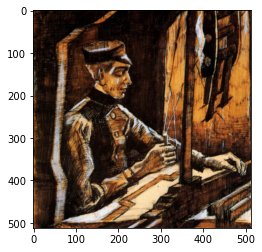

In [15]:
indexes = [20811, 114981, 6134, 53197, 88402, 95770]
content_samples = [torch.unsqueeze(env._content_dataset.__getitem__(index, False), 0) for index in indexes]

indexes = [76648, 12486]
style_samples = [torch.unsqueeze(env._style_dataset.__getitem__(index, False), 0) for index in indexes]

for index in indexes:
    batch = torchvision.transforms.ToPILImage()(env._style_dataset.__getitem__(index, False))
    plt.imshow(batch)
    plt.show()

# save_stylization(content_samples, style_samples, env)

In [13]:
'''
for i in tqdm(range(5000)):
    content_images = next(env.content_loader).to(env.device)
    style_images = next(env.style_loader).to(env.device)

    torchvision.utils.save_image(
        torchvision.utils.make_grid(
            [inv_normalize(s) for s in style_images],
            nrow=4,
        ),
        f"samples/style_{str(i+1).zfill(6)}.png",
    )
    print(content_images)

    torchvision.utils.save_image(
        torchvision.utils.make_grid(
            [inv_normalize(c) for c in content_images],
            nrow=4,
        ),
        f"samples/content_{str(i+1).zfill(6)}.png",
    )

    break
'''

'\nfor i in tqdm(range(5000)):\n    content_images = next(env.content_loader).to(env.device)\n    style_images = next(env.style_loader).to(env.device)\n\n    torchvision.utils.save_image(\n        torchvision.utils.make_grid(\n            [inv_normalize(s) for s in style_images],\n            nrow=4,\n        ),\n        f"samples/style_{str(i+1).zfill(6)}.png",\n    )\n    print(content_images)\n\n    torchvision.utils.save_image(\n        torchvision.utils.make_grid(\n            [inv_normalize(c) for c in content_images],\n            nrow=4,\n        ),\n        f"samples/content_{str(i+1).zfill(6)}.png",\n    )\n\n    break\n'

In [14]:
start_iteration = 111000
pbar = tqdm(range(start_iteration, env.iters))

losses = {"Lc": [], "Ls": [], "loss_lambda1": [], "loss_lambda2": [], "loss": []}
losses_ma = {"Lc": [], "Ls": [], "loss_lambda1": [], "loss_lambda2": [], "loss": []}

if start_iteration != 0:
    env.load_save(f"model_save/{str(start_iteration).zfill(6)}.pt")

  0%|          | 0/139000 [00:00<?, ?it/s]

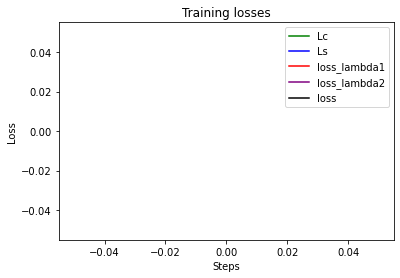

loss: 12.719762802124023, Lc: 2.5218992233276367, Ls: 5.875272750854492, lambda1: 0.28088822960853577, lambda2: 4.041701793670654:  19%|█▊        | 25736/139000 [4:02:34<40:00:56,  1.27s/it]

In [16]:
for i in pbar:
    # Adjust learning rate
    if i + 1 > env.decay_after:
        for param_group in env.optimizer.param_groups:
            param_group['lr'] *= env.lr_decay
    with torch.cuda.amp.autocast():
        content_images = next(env.content_loader).to(env.device)
        style_images = next(env.style_loader).to(env.device)

        Lc, Ls, loss_lambda1, loss_lambda2 = env.network(content_images, style_images)

        Lc *= env.content_weight
        Ls *= env.style_weight
        loss_lambda1 *=  env.identity1_weight 
        loss_lambda2 *=  env.identity2_weight 
        loss = Lc + Ls + loss_lambda1 + loss_lambda2

    env.optimizer.zero_grad()
    loss.backward()

    for params in env.network.decoder.parameters():
        torch.nan_to_num_(params.grad, nan=0, posinf=1e5, neginf=-1e5)
    for params in env.network.sa_module.parameters():
        torch.nan_to_num_(params.grad, nan=0, posinf=1e5, neginf=-1e5)


    env.optimizer.step()

    losses["Lc"].append(Lc.detach().cpu().numpy())
    losses["Ls"].append(Ls.detach().cpu().numpy())
    losses["loss_lambda1"].append(loss_lambda1.detach().cpu().numpy())
    losses["loss_lambda2"].append(loss_lambda2.detach().cpu().numpy())
    losses["loss"].append(loss.detach().cpu().numpy())

    if not (i + 1) % env.log_generated_interval:
        losses_ma["Lc"].append(np.array(losses["Lc"][-env.log_generated_interval + 1:]).mean())
        losses_ma["Ls"].append(np.array(losses["Ls"][-env.log_generated_interval + 1:]).mean())
        losses_ma["loss_lambda1"].append(np.array(losses["loss_lambda1"][-env.log_generated_interval + 1:]).mean())
        losses_ma["loss_lambda2"].append(np.array(losses["loss_lambda2"][-env.log_generated_interval + 1:]).mean())
        losses_ma["loss"].append(np.array(losses["loss"][-env.log_generated_interval + 1:]).mean())

        clear_output(wait=True)
        plt.plot(range(len(losses_ma["Lc"])), losses_ma["Lc"], 'g', label='Lc')
        plt.plot(range(len(losses_ma["Ls"])), losses_ma["Ls"], 'b', label='Ls')
        plt.plot(range(len(losses_ma["loss_lambda1"])), losses_ma["loss_lambda1"], 'r', label='loss_lambda1')
        plt.plot(range(len(losses_ma["loss_lambda2"])), losses_ma["loss_lambda2"], 'purple', label='loss_lambda2')
        plt.plot(range(len(losses_ma["loss"])), losses_ma["loss"], 'black', label='loss')
        plt.title('Training losses')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    if not (i + 1) % env.img_generated_interval:
        save_stylization(content_samples, style_samples, env, i)

    if not (i + 1) % env.save_checkpoint_interval:
        losses_file = open("loss_save/losses.pkl", "wb")
        losses_ma_file = open("loss_save/losses_ma.pkl", "wb")
        pickle.dump(losses, losses_file)
        pickle.dump(losses_ma, losses_ma_file)

        torch.save({
            "decoder": env.network.decoder.state_dict(),
            "sa_module": env.network.sa_module.state_dict(),
            "optimizer": env.optimizer.state_dict()
        }, f"model_save/{str(i+1).zfill(6)}.pt")

    pbar.set_description("loss: {}, Lc: {}, Ls: {}, lambda1: {}, lambda2: {}".format(loss.detach().cpu().numpy(), Lc.detach().cpu().numpy(), Ls.detach().cpu().numpy(), loss_lambda1.detach().cpu().numpy(), loss_lambda2.detach().cpu().numpy()))